<h1>Ecological Consumption and its relationship to GDP</h1>

A country’s ecological assets can have a great impact on what it produces in its economy. For example, countries with abundant natural supplies of oil, distribute oil worldwide and it contributes to most of their economic activity. Because of this, we have decided to investigate whether or not the amount of ecological assets a country has impacts their GDP Per Capita. The question we are trying to answer is: Are ecological assets a good predictor of a country’s GDP Per Capita?

The data set we will be using is called “2016 Global Ecological Footprint,” by the Global Footprint Network. This dataset contains information about several countries' ecological footprints, with several observations about their ecological assets such as farmland and urban land. It also has the countries GDP per Capita,  which we will categorize and predict in our model.

In [1]:
# required libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# importing untidy data set
url <- "https://docs.google.com/spreadsheets/d/e/2PACX-1vR_6ci0B-tyn-2T5ywr5cOSxgtls94IPi3zrpu5z3fNxDyK8R1985IH1Uq3zd253ufZIr8Y1tgxffnq/pub?output=csv"

countries_raw_data <- read_csv(url)

#the following steps aim to tidy the data set


#renaming columns to make them syntactically valid

colnames(countries_raw_data) <- tolower(make.names(colnames(countries_raw_data)))

Parsed with column specification:
cols(
  .default = col_double(),
  Country = col_character(),
  Region = col_character(),
  `GDP per Capita` = col_character(),
  `Data Quality` = col_character()
)

See spec(...) for full column specifications.



Here we are selecting the columns that we need from the dataframe. This includes the country's name, GDP per Capita, and the ecological footprints.

In [3]:
countries_GDP_eco <- countries_raw_data %>% select(country, cropland.footprint, 
                                                  grazing.footprint, forest.footprint, 
                                                  fish.footprint, carbon.footprint, gdp.per.capita)

# removing any rows that have an NA cell
countries_GDP_eco <- na.omit(countries_GDP_eco)


# removing the "$" sign and "," from all elements of the gdp.per.capita column
countries_GDP_eco <-  countries_GDP_eco %>% 
                         mutate(gdp.per.capita = gsub("[^[:alnum:][:space:].]", "",
                                                      countries_GDP_eco$gdp.per.capita))

# converting gdp.per.capita from a character data type to double

countries_GDP_eco <- countries_GDP_eco %>% mutate(gdp.per.capita = as.numeric(gdp.per.capita))
countries_GDP_eco

# the following steps are for categorizing the gdp.per.capita column into "High", "Medium", and "low"

# arranging the gdp.per.capita column in an ascending order
countries_GDP_eco <- arrange(countries_GDP_eco, gdp.per.capita)

country,cropland.footprint,grazing.footprint,forest.footprint,fish.footprint,carbon.footprint,gdp.per.capita
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,0.30,0.20,0.08,0.00,0.18,614.66
Albania,0.78,0.22,0.25,0.02,0.87,4534.37
Algeria,0.60,0.16,0.17,0.01,1.14,5430.57
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Yemen,0.34,0.14,0.04,0.04,0.42,1302.30
Zambia,0.19,0.18,0.33,0.01,0.24,1740.64
Zimbabwe,0.20,0.32,0.29,0.01,0.53,865.91


We also classify the GDP into either "low", "lower middle", "upper middle" or "high". These classifications were taken from https://blogs.worldbank.org/opendata/new-world-bank-country-classifications-income-level-2020-2021.

In [13]:
countries_GDP_eco_classified <- countries_GDP_eco %>% 
    mutate(GDP_classified = cut(countries_GDP_eco$gdp.per.capita,
                                breaks = c(0, 1036, 4045, 12535, Inf),
                                labels = c("low", "lower middle", "upper middle", "high")))

We generate the training and testing data sets using our main data set. A proportion of 75% was dedicated to the training data set, and 25% for the testing data set. This was because our data frame had less than 500 rows.

In [5]:
set.seed(1)
countries_split <- initial_split(countries_GDP_eco_classified, prop = 0.75, strata = GDP_classified)
countries_train <- training(countries_split)
countries_test <- testing(countries_split)

In [6]:
# the following steps give a summary of the data, using only the training set. 

# table giving the means of each of the predictors
countries_train_predictors <- countries_train %>%
    select(cropland.footprint, grazing.footprint, forest.footprint, fish.footprint, carbon.footprint)

mean_of_predictors <- map_df(countries_train_predictors, mean)

mean_of_predictors

cropland.footprint,grazing.footprint,forest.footprint,fish.footprint,carbon.footprint
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.598871,0.2418548,0.3933871,0.1121774,1.807581


We want to create the recipe for our algorithm. We do not have to scale our predictors because the initial data is already scaled. We also want to perform a cross-validation because we want to find the most optimal $k$ value for our k-nn classification. We then want to collect the metrics from the workflow analysis.

In [25]:
set.seed(1)
#creating our recipe
countries_recipe <- recipe(GDP_classified ~ cropland.footprint + grazing.footprint + forest.footprint + 
                           fish.footprint + carbon.footprint, data = countries_train)

#cross-validation
countries_vfold <- vfold_cv(countries_train, v = 5, strata = GDP_classified)

#specifications for our model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

#workflow analysis metrics
countries_results <- workflow() %>%
      add_recipe(countries_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = countries_vfold, grid = 10) %>%
      collect_metrics()

countries_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5717949,5,0.04970119,Model1
1,roc_auc,hand_till,0.7182143,5,0.03301866,Model1
3,accuracy,multiclass,0.5557692,5,0.04046086,Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,hand_till,0.8084403,5,0.03623922,Model8
14,accuracy,multiclass,0.5320513,5,0.03326238,Model9
14,roc_auc,hand_till,0.8012472,5,0.03242552,Model9


The metrics are now used in order to graph out the $k$ value vs the Accuracy Estimate. We use this graph to find the best $k$ value for our dataset.

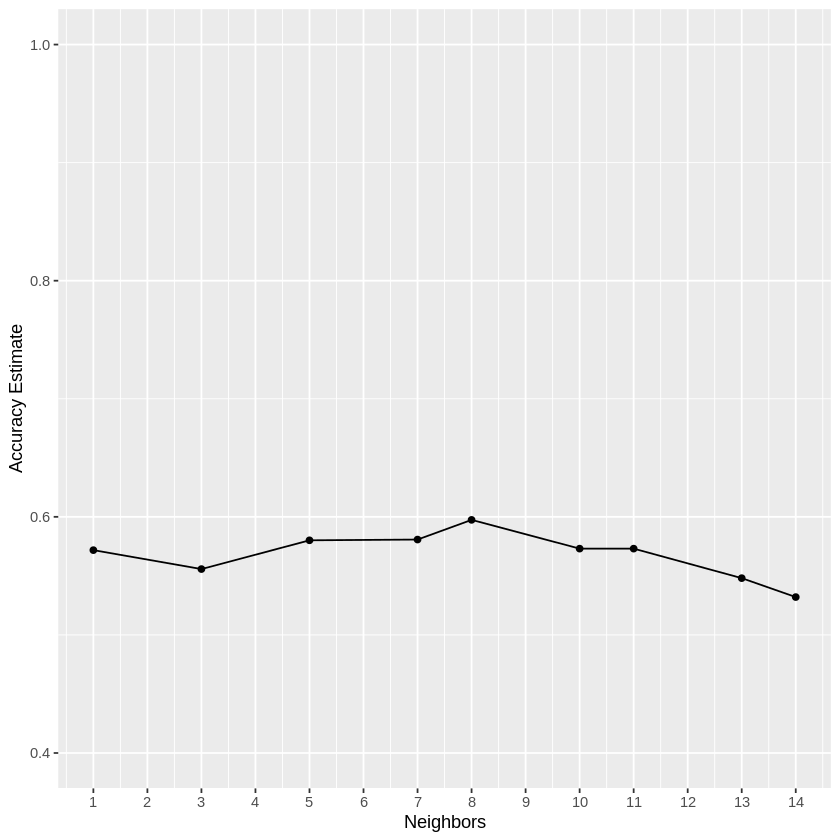

In [26]:
#filtering out the metrics to only display accuracy
accuracies <- countries_results %>% 
      filter(.metric == "accuracy")

#plotting out the k vs accuracy estimate in order to visualize the relationship between them.
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0))

cross_val_plot

From the graph above we can choose the best $k$ value for our specifications. We will choose the $k$ = 8 value because it seems to be the most accurate and it most likely will not over-fit or under-fit.

In [27]:
set.seed(2) 

# creating new knn specification using the k value we got from the graph
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 8) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# creating the fit using the training data
countries_fit <- workflow() %>%
      add_recipe(countries_recipe) %>%
      add_model(knn_spec) %>%
      fit(data = countries_train)

In [28]:
set.seed(2) 

# predicting the GDP_classified of the test data
countries_predictions <- predict(countries_fit, countries_test) %>%
    bind_cols(countries_test)

countries_predictions

# finding the accuracy of the prediction
countries_metrics <- countries_predictions %>%
    metrics(truth = GDP_classified, estimate = .pred_class)

countries_metrics

# finding the confusion matrix of the prediction
countries_conf_mat <- countries_predictions %>%
    conf_mat(truth = GDP_classified, estimate = .pred_class)

countries_conf_mat

.pred_class,country,cropland.footprint,grazing.footprint,forest.footprint,fish.footprint,carbon.footprint,gdp.per.capita,GDP_classified
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
upper medium,Niger,0.67,0.48,0.26,0.02,0.10,410.91,low
lower medium,Madagascar,0.27,0.34,0.24,0.02,0.07,456.33,low
low,Malawi,0.43,0.05,0.20,0.01,0.07,493.84,low
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
high,Austria,0.82,0.27,0.63,0.06,4.14,51274.1,high
high,Canada,1.46,0.33,1.20,0.12,5.00,52145.4,high
high,Netherlands,0.76,0.58,0.38,0.16,3.23,53589.9,high


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5128205
kap,multiclass,0.3425022


              Truth
Prediction     low lower medium upper medium high
  low            4            3            1    0
  lower medium   2            1            4    0
  upper medium   1            3            6    3
  high           0            2            0    9